# 주제 : DIOR & YSL 립 제품 리뷰 분석

### 목차

<font color = "#CC3D3D"><p>

- [웹스크래핑 - Selenium](#웹스크래핑---Selenium)
- [데이터 전처리](#데이터-전처리)
    - [이모티콘 및 특수문자 제거하기](#이모티콘-및-특수문자-제거하기)
    - [형태소 분석 및 단어 문서 행렬 만들기](#형태소-분석-및-단어-문서-행렬-만들기)
- [단어 빈도](#단어-빈도)
    - [단어구름](#단어구름)
    - [브랜드별 단어구름 비교](#브랜드별-단어구름-비교)
- [감성 분석](#감성-분석)
- [주제 분석](#주제-분석)
    - [전체 주제 분석](#전체-주제-분석)
    - [LDA - DIOR](#LDA--DIOR)
    - [LDA - YSL](#LDA---YSL)

In [81]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from wordcloud import WordCloud
from selenium.webdriver import Chrome
from kiwipiepy import Kiwi
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot
from factor_analyzer.rotator import Rotator
from sklearn.decomposition import NMF
import tensorflow as tf
import spacy
import lxml.html
import requests
import re
import os
import stanza
import joblib
import time
from gensim.matutils import Sparse2Corpus
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pyLDAvis.gensim
from gensim.models import CoherenceModel
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt

# 웹스크래핑 - Selenium

selenium을 활용하여 각 브랜드의 리뷰를 스크래핑하는 함수와 for문을 만들어 리뷰 웹 스크래핑을 진행했다.

- 디올 리뷰 웹스크래핑

In [6]:
browser = Chrome()
url = 'http://department.ssg.com/item/itemView.ssg?itemId=0000000158137&siteNo=6009&salestrNo=1004'

browser.get(url)
time.sleep(2)

# 고객 리뷰 클릭
review_page = browser.find_elements_by_css_selector('#_cdtl_dtlcont_wrap > div.cdtl_dtlcont_lft > div > div.cdtl_tab_fixed > ul > li:nth-child(2) > a')
review_page[0].click()

# for문 범위 지정을 위한 총 리뷰 개수 추출
last = browser.find_elements_by_css_selector('#cdtl_cmt_tbody > tr:nth-child(1) > td.number > div')
last_page = last[0].text
page_10 = int(last_page)//100
page_end = int(last_page)%10
page_last = int(last_page)%100//10 if page_end == 0 else int(last_page)%100//10 + 1


dior_re = []
dior_st = []

# 리뷰 및 별점 스크래핑 함수
def review_star() :
    for review in browser.find_elements_by_css_selector('a.clickable div.cdtl_cmt_tx.v2 span.desc'):
        dior_re.append(review.text)
    time.sleep(1)
    for star in browser.find_elements_by_css_selector('td.star div.in span.sp_cdtl.cdtl_cmt_star span.sp_cdtl.cdtl_cmt_per'):
        dior_st.append(star.text)
    time.sleep(1)
            
# 다음 페이지로 넘기는 함수        
def next_page() :
    url = f'#comment_navi_area > a:nth-child({i})'
    next_page = browser.find_elements_by_css_selector(url)
    next_page[0].click()
    time.sleep(2)
    
    
    
## 웹스크래핑

review_star()  # 첫페이지 웹스크래핑

i = 2          
next_page()    # 두번째 페이지 웹스크래핑 

for i in range(4,13) :        # 3~10p 스크래핑
    review_star()
    next_page()
    
for j in range(page_10 -1) :  # 10 페이지 단위로 스크래핑 
    for i in range(4,14) :
        review_star()
        next_page()

- 데이터 프레임으로 변환

In [7]:
dior_review = pd.DataFrame(dior_re , columns = ['review'])
dior_star = pd.DataFrame(dior_st , columns = ['star'])
dior_content = pd.concat([dior_review , dior_star], axis = 1)


dior_content['point'] = dior_content['star'].apply(lambda x : int(x[-2]))
del dior_content['star']

dior_content.to_csv('dior_', index = False)

- 입생로랑 리뷰 웹스크래핑

In [62]:
browser = Chrome()
url = 'http://department.ssg.com/item/itemView.ssg?itemId=0000004867402&siteNo=6009&salestrNo=1004'

browser.get(url)
time.sleep(2)

# 고객 리뷰 클릭
review_page = browser.find_elements_by_css_selector('#_cdtl_dtlcont_wrap > div.cdtl_dtlcont_lft > div > div.cdtl_tab_fixed > ul > li:nth-child(2) > a')
review_page[0].click()

# for문 범위 지정을 위한 총 리뷰 개수 추출
last = browser.find_elements_by_css_selector('#cdtl_cmt_tbody > tr:nth-child(1) > td.number > div')
last_page = last[0].text
page_10 = int(last_page)//100
page_end = int(last_page)%10
page_last = int(last_page)%100//10 if page_end == 0 else int(last_page)%100//10 + 1


ysl_re = []
ysl_st = []

# 리뷰 및 별점 스크래핑 함수
def review_star() :
    for review in browser.find_elements_by_css_selector('a.clickable div.cdtl_cmt_tx.v2 span.desc'):
        ysl_re.append(review.text)
    time.sleep(1)
    for star in browser.find_elements_by_css_selector('td.star div.in span.sp_cdtl.cdtl_cmt_star span.sp_cdtl.cdtl_cmt_per'):
        ysl_st.append(star.text)
    time.sleep(1)
            
# 다음 페이지로 넘기는 함수        
def next_page() :
    url = f'#comment_navi_area > a:nth-child({i})'
    next_page = browser.find_elements_by_css_selector(url)
    next_page[0].click()
    time.sleep(2)
    
    
    
## 웹스크래핑

review_star()  # 첫페이지 웹스크래핑

i = 2          
next_page()    # 두번째 페이지 웹스크래핑 

for i in range(4,13) :        # 3~10p 스크래핑
    review_star()
    next_page()
    
for j in range(page_10 -1) :  # 10 페이지 단위로 스크래핑 
    for i in range(4,14) :
        review_star()
        next_page()

- 데이터 프레임으로 변환

In [63]:
ysl_review = pd.DataFrame(ysl_re , columns = ['review'])
ysl_star = pd.DataFrame(ysl_st , columns = ['star'])
ysl_content = pd.concat([ysl_review , ysl_star], axis = 1)

In [64]:
ysl_content.dropna(inplace = True)

In [65]:
ysl_content['point'] = ysl_content['star'].apply(lambda x : int(x[-2]))
del ysl_content['star']

ysl_content.to_csv('ysl_', index = False)

# 데이터 전처리

### 이모티콘 및 특수문자 제거하기

아래에 첨부한 참고 자료를 활용하여 리뷰 안에 포함된 이모티콘 및 특수문자를 제거하였다.

In [408]:
dior = pd.read_csv('dior_')
ysl = pd.read_csv('ysl_')

In [409]:
dior['sentiment'] = 1
ysl['sentiment'] = 0

In [413]:
def clean_text(texts): 
    review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"]', '',str(texts)) 
    review = review.lower() 
    review = re.sub(r'\s+', ' ', review) 
    review = re.sub(r'<[^>]+>','',review) 
    review = re.sub(r'\s+', ' ', review) 
    review = re.sub(r"^\s+", '', review) 
    review = re.sub(r'\s+$', '', review) 
    return review

In [414]:
def no_emoji(text) :
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
# 참고 자료 : https://ebbnflow.tistory.com/246 
# 참고 자로 : https://studyprogram.tistory.com/entry/Python%EC%97%90%EC%84%9C-%ED%85%8D%EC%8A%A4%ED%8A%B8-%EC%95%88%EC%9D%98-%EC%9D%B4%EB%AA%A8%EC%A7%80emoji%EC%A0%9C%EA%B1%B0%ED%95%98%EA%B8%B0

In [459]:
dior['review'] = dior['review'].apply(clean_text)
dior['review'] = dior['review'].apply(no_emoji)

ysl['review'] = ysl['review'].apply(clean_text)
ysl['review'] = ysl['review'].apply(no_emoji)

In [463]:
data = pd.concat([dior, ysl]) 

In [464]:
data.dropna(axis = 0 , inplace = True)
data = data.reset_index()
del data['index']

### 형태소 분석 및 단어 문서 행렬 만들기

stanza를 활용하여 형태소 분석을 진행하고 명사만 포함하는 tdm을 CountVectorizer와 TfidfVectorizer을 각각 사용하여 만들었다. 

In [6]:
nlp = stanza.Pipeline('ko')

2021-04-29 10:04:56 INFO: Loading these models for language: ko (Korean):
| Processor | Package |
-----------------------
| tokenize  | kaist   |
| pos       | kaist   |
| lemma     | kaist   |
| depparse  | kaist   |

2021-04-29 10:04:57 INFO: Use device: gpu
2021-04-29 10:04:57 INFO: Loading: tokenize
2021-04-29 10:04:58 INFO: Loading: pos
2021-04-29 10:04:59 INFO: Loading: lemma
2021-04-29 10:04:59 INFO: Loading: depparse
2021-04-29 10:04:59 INFO: Done loading processors!


In [466]:
def extract_nouns(text):
    doc = nlp(text)
    for sentence in doc.sentences:
        for word in sentence.words:
            lemma = word.lemma.split('+')
            xpos = word.xpos.split('+')
            for lem, pos in zip(lemma, xpos):
                if pos.startswith('n') :
                    yield lem

- CountVectorizer

In [424]:
cv = CountVectorizer(max_features=1000 , tokenizer=extract_nouns)

In [425]:
tdm = cv.fit_transform(data['review'])

In [426]:
word_count = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat
}).sort_values('빈도', ascending=False)

In [427]:
words = cv.get_feature_names()

In [429]:
count_dic = word_count.set_index('단어')['빈도'].to_dict()

- TfidfVectorizer

In [471]:
tfidf = TfidfVectorizer(max_features = 1000, tokenizer=extract_nouns)

In [472]:
tfidf_tdm = tfidf.fit_transform(data['review'])

In [473]:
tfidf_word_count = pd.DataFrame({
    '단어' : tfidf.get_feature_names(),
    '빈도' : tfidf_tdm.sum(axis=0).flat 
})

In [474]:
tfidf_count_dic = tfidf_word_count.set_index('단어')['빈도'].to_dict()

# 단어 빈도

CountVectorizer를 이용하여 만든 단어 빈도표와 TfidfVectorizer를 이용하여 만든 단어 빈도표를 만들었다.

In [526]:
display(word_count.sort_values('빈도', ascending=False).head(10) ,tfidf_word_count.sort_values('빈도', ascending = False ).head(10))

,단어,빈도
118,구매,2391
786,제품,2306
486,색상,2227
462,사용,2206
501,선물,2066
382,발색,1948
481,색,1806
387,배송,1484
731,입술,1406
312,만족,1403


,단어,빈도
501,선물,874.418908
786,제품,817.753163
486,색상,773.808135
118,구매,733.871524
462,사용,679.655097
387,배송,673.745883
481,색,663.745389
382,발색,653.242036
312,만족,570.154227
849,촉촉,503.630672


### 단어 구름

단어구름을 CountVectorizer와 TfidfVectorizer별로 각각 그려보았다. 이때, mask 파라미터와 ImageColorGenerator를 사용하여 단어 구름 모양 및 색상을 지정하여 뽑아주었다. 립 제품에 대한 단어 구름인만큼 입술 모양의 단어 구름을 만들었다.

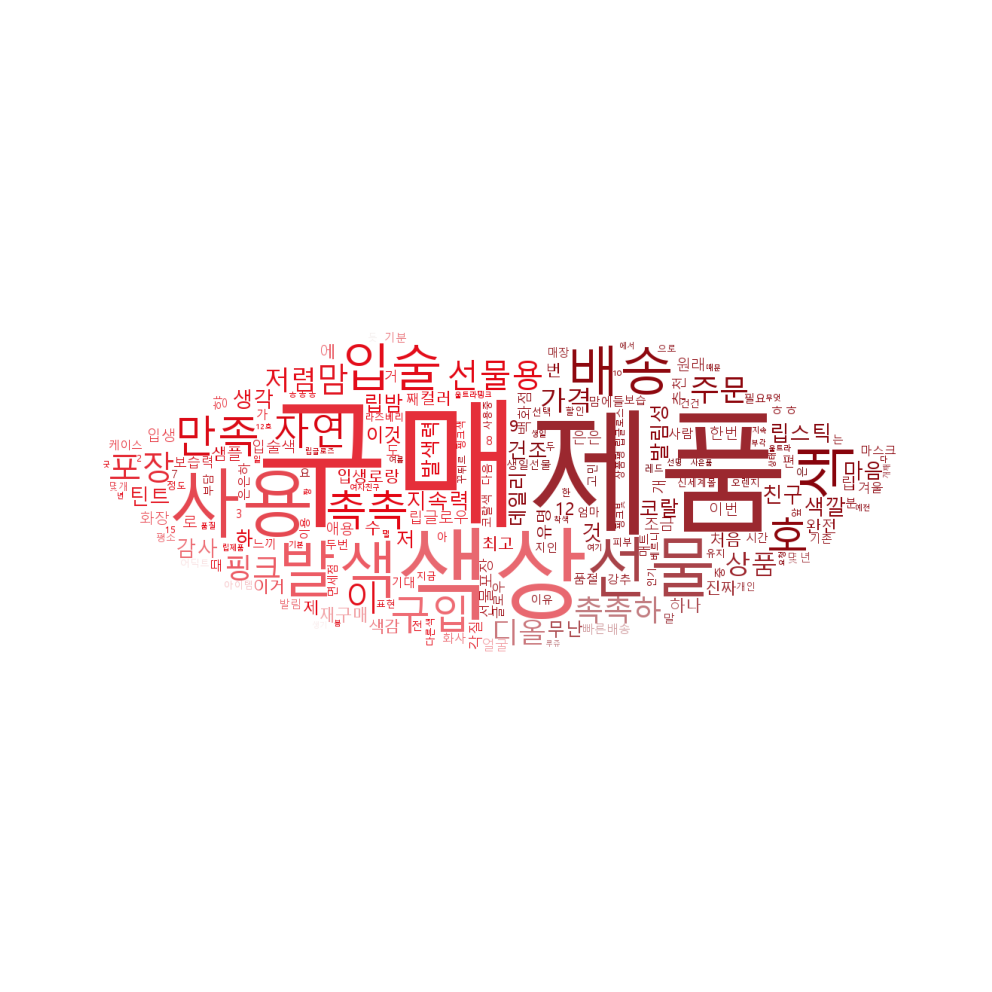

In [494]:
coloring = np.array(Image.open("/Users\gimje\OneDrive\바탕 화면/lip1.jpg"))


from wordcloud import ImageColorGenerator
image_colors = ImageColorGenerator(coloring)


from wordcloud import WordCloud
wordcloud = WordCloud(font_path="C:/Windows/Fonts/Malgun.ttf", 
                      mask=coloring, background_color='white').generate_from_frequencies(count_dic)


import matplotlib.pyplot as plt
plt.figure(figsize=(18,18)) 
plt.imshow(wordcloud.recolor(color_func=image_colors))
plt.axis('off')
plt.savefig('wordcloud_final.jpg')
plt.show()

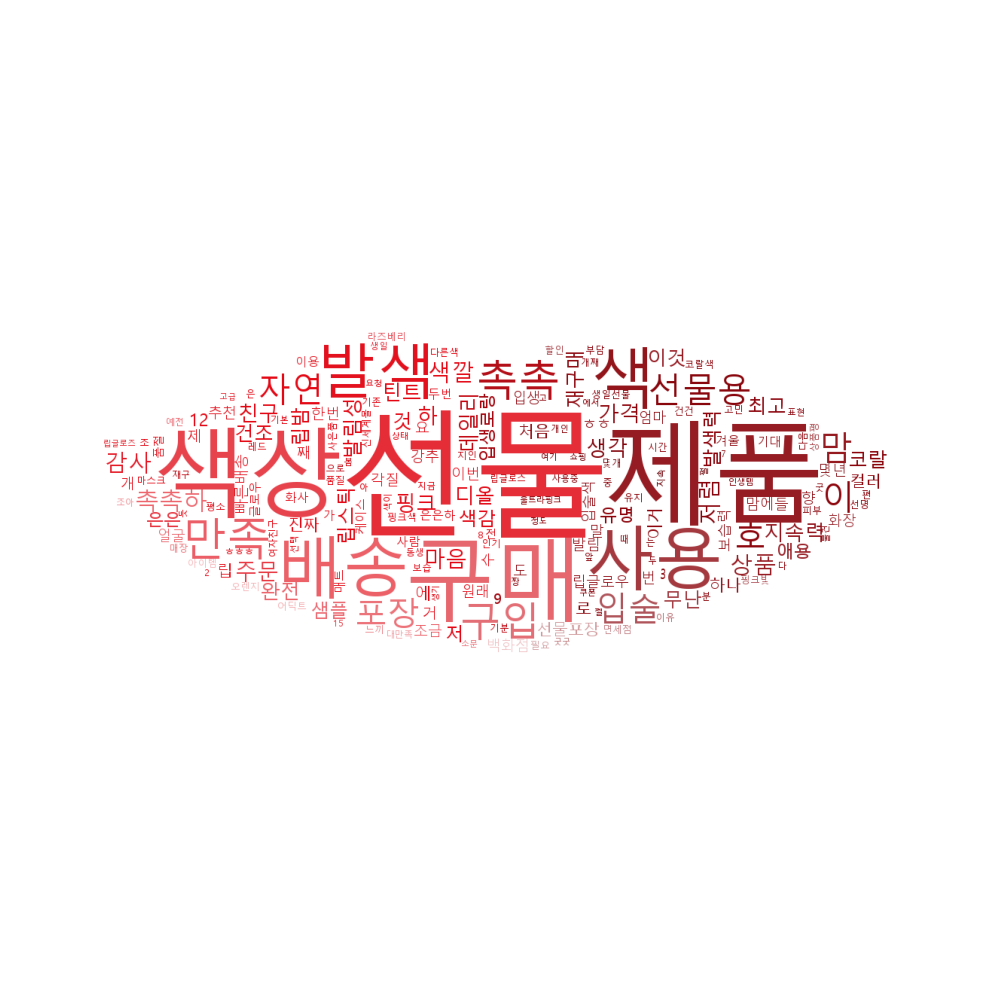

In [493]:
coloring = np.array(Image.open("/Users\gimje\OneDrive\바탕 화면/lip1.jpg"))


from wordcloud import ImageColorGenerator
image_colors = ImageColorGenerator(coloring)


from wordcloud import WordCloud
wordcloud = WordCloud(font_path="C:/Windows/Fonts/Malgun.ttf", 
                      mask=coloring, background_color='white').generate_from_frequencies(tfidf_count_dic)


import matplotlib.pyplot as plt
plt.figure(figsize=(18,18)) 
plt.imshow(wordcloud.recolor(color_func=image_colors))
plt.axis('off')
plt.savefig('tfidf_wordcloud_final.jpg')
plt.show()

### 브랜드별 단어구름 비교

dior과 ysl 별로 단어 빈도를 확인하기 위해 단어 구름을 그리고 비교해보았다. 단어 구름을 통해 알 수 있는 두 브랜드의 가장 큰 차이점은 색상이 다양하고 1호, 2호, ... 등으로 색상명을 사용하는 ysl의 단어 구름에 "호"가 큰 비중을 차지한다는 점이다.

In [478]:
dior.dropna(axis = 0 , inplace = True)
ysl.dropna(axis = 0 , inplace = True)

- dior

In [479]:
diorcv = CountVectorizer(max_features=1000 , tokenizer=extract_nouns)

In [480]:
diortdm = diorcv.fit_transform(dior['review'])

In [481]:
diorword_count = pd.DataFrame({
    '단어': diorcv.get_feature_names(),
    '빈도': diortdm.sum(axis=0).flat
}).sort_values('빈도', ascending=False)

In [482]:
diorwords = diorcv.get_feature_names()

In [483]:
diorcount_dic = word_count.set_index('단어')['빈도'].to_dict()

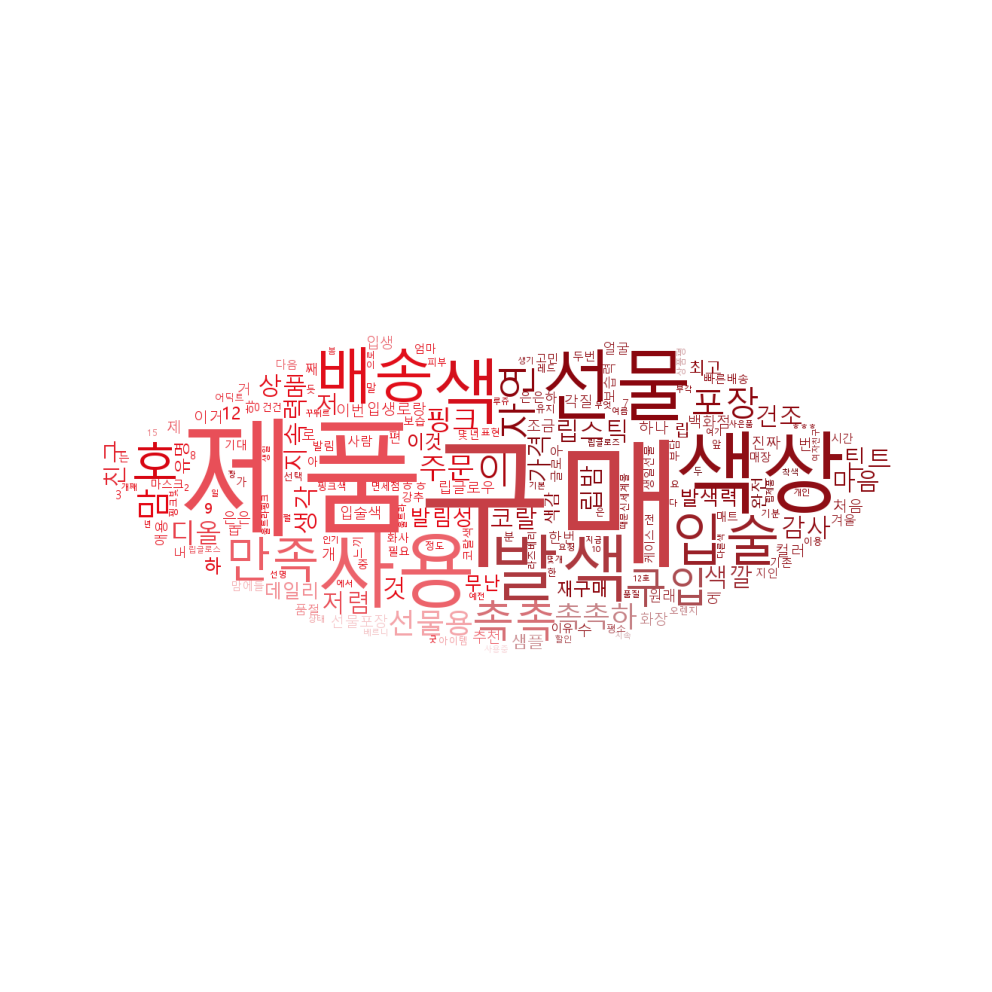

In [484]:
coloring = np.array(Image.open("/Users\gimje\OneDrive\바탕 화면/lip1.jpg"))


from wordcloud import ImageColorGenerator
image_colors = ImageColorGenerator(coloring)


from wordcloud import WordCloud
wordcloud = WordCloud(font_path="C:/Windows/Fonts/Malgun.ttf", 
                      mask=coloring, background_color='white').generate_from_frequencies(diorcount_dic)


import matplotlib.pyplot as plt
plt.figure(figsize=(18,18)) 
plt.imshow(wordcloud.recolor(color_func=image_colors))
plt.axis('off')
plt.savefig('wordcloud_final.jpg')
plt.show()

- ysl

In [485]:
yslcv = CountVectorizer(max_features=1000 , tokenizer=extract_nouns)

In [486]:
ysltdm = yslcv.fit_transform(ysl['review'])

In [487]:
yslword_count = pd.DataFrame({
    '단어': yslcv.get_feature_names(),
    '빈도': ysltdm.sum(axis=0).flat
}).sort_values('빈도', ascending=False)

In [488]:
yslwords = yslcv.get_feature_names()

In [489]:
yslcount_dic = yslword_count.set_index('단어')['빈도'].to_dict()

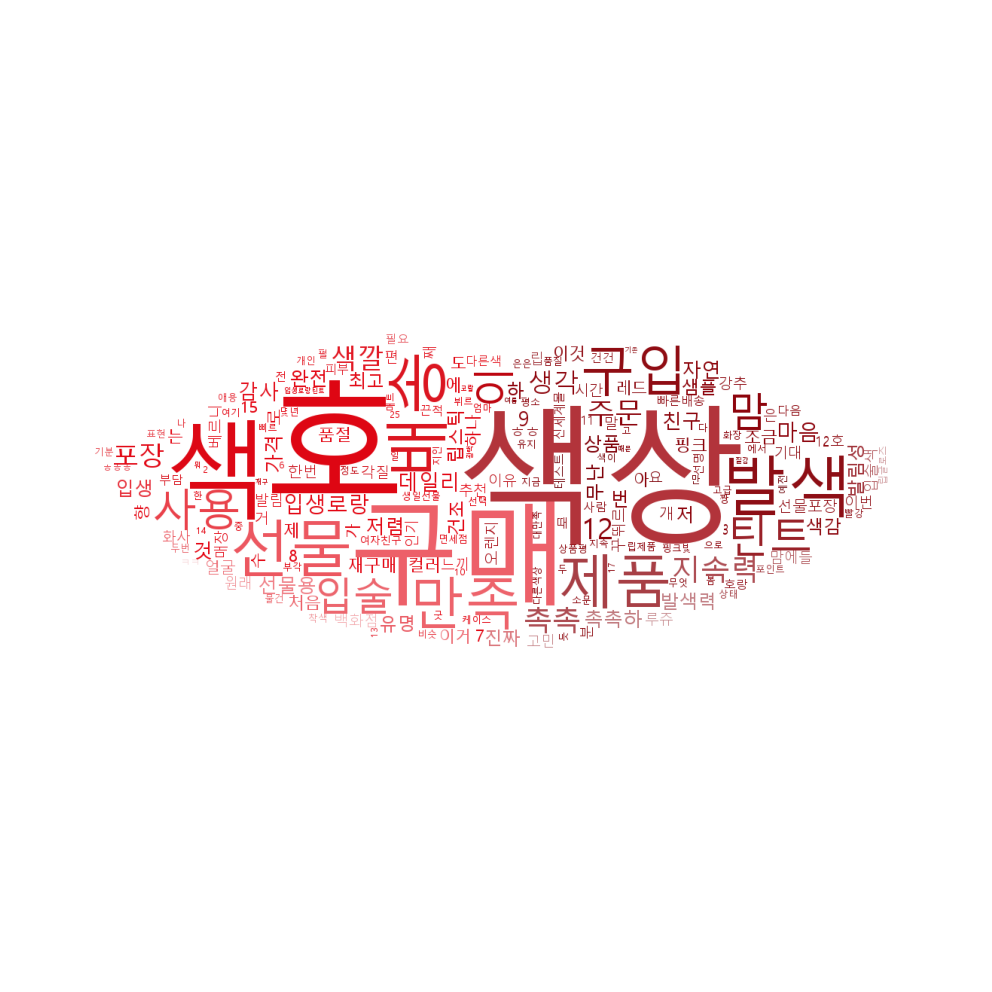

In [490]:
coloring = np.array(Image.open("/Users\gimje\OneDrive\바탕 화면/lip1.jpg"))

from wordcloud import ImageColorGenerator
image_colors = ImageColorGenerator(coloring)


from wordcloud import WordCloud
wordcloud = WordCloud(font_path="C:/Windows/Fonts/Malgun.ttf", 
                      mask=coloring, background_color='white').generate_from_frequencies(yslcount_dic)


import matplotlib.pyplot as plt
plt.figure(figsize=(18,18)) 
plt.imshow(wordcloud.recolor(color_func=image_colors))
plt.axis('off')
plt.savefig('wordcloud_final.jpg')
plt.show()

In [ ]:
# 참고 자료 : https://todaygnimaerd.tistory.com/19

# 감성 분석

dior에 대한 리뷰를 1 , ysl(입생로랑)에 대한 리뷰를 0으로 감성 분석을 진행하였다. 위에서 만든 2가지 tdm을 사용하여 감성 분석을 진행하였고 비슷한 정확도를 얻을 수 있었다. 이에 뒤에서 진행하는 주제분석은 countvectorizer를 이용하여 만든 tdm으로만 분석을 진행하였다.

- TF-IDF TDM 활용

In [495]:
tfidf_tdm

<22699x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 82123 stored elements in Compressed Sparse Row format>

In [496]:
x = dtm
y = data['sentiment'].values[:22699]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [497]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [498]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [499]:
model.fit(x_train.A , y_train , epochs = 3 )

Epoch 1/3
568/568 [==============================] - 2s 3ms/step - loss: 0.6691 - accuracy: 0.6115
Epoch 2/3
568/568 [==============================] - 2s 3ms/step - loss: 0.6116 - accuracy: 0.6859
Epoch 3/3
568/568 [==============================] - 2s 3ms/step - loss: 0.5811 - accuracy: 0.7012


In [500]:
model.evaluate(x_test.A , y_test)

142/142 [==============================] - 0s 2ms/step - loss: 0.5777 - accuracy: 0.6980


[0.5777093768119812, 0.6980175971984863]

In [501]:
w, b = model.weights

In [502]:
word_sent = pd.DataFrame({'토큰': words, '가중치': w.numpy().flat})

In [503]:
word_sent.sort_values('가중치').head(20)

,토큰,가중치
908,틴트,-0.837964
977,호,-0.804959
727,입생로랑,-0.735100
725,입생,-0.734992
7,12,-0.724526
36,9,-0.667351
816,지속력,-0.592945
486,색상,-0.552694
271,레드,-0.547870
8,12호,-0.450832


In [504]:
word_sent.sort_values('가중치').tail(20)

,토큰,가중치
417,보호,0.326161
291,립,0.342705
253,디올립밤,0.351308
300,립밤이,0.357634
503,선물용,0.377896
786,제품,0.402763
663,울트라,0.411583
577,어딕트,0.419266
664,울트라핑크,0.421798
462,사용,0.426999


- CountVectorizer TDM 활용

In [505]:
tdm

<22699x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 82123 stored elements in Compressed Sparse Row format>

In [506]:
joblib.dump({'words': words, 'dtm': tdm}, 'dior_ysl.pkl')

['dior_ysl.pkl']

In [507]:
dior_ysl_tdm = joblib.load('dior_ysl.pkl')

In [508]:
locals().update(dior_ysl_tdm) 

In [509]:
x = dtm
y = data['sentiment'].values[:22699]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [510]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [511]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [512]:
model.fit(x_train.A , y_train , epochs = 3 )

Epoch 1/3
568/568 [==============================] - 2s 3ms/step - loss: 0.6765 - accuracy: 0.5786
Epoch 2/3
568/568 [==============================] - 2s 3ms/step - loss: 0.6174 - accuracy: 0.6886
Epoch 3/3
568/568 [==============================] - 2s 3ms/step - loss: 0.5826 - accuracy: 0.7039


In [513]:
model.evaluate(x_test.A , y_test)

142/142 [==============================] - 0s 2ms/step - loss: 0.5801 - accuracy: 0.6991


[0.5800700187683105, 0.699118971824646]

In [514]:
model.save('diorysl0.krs')

INFO:tensorflow:Assets written to: diorysl0.krs\assets


In [515]:
model = tf.keras.models.load_model('diorysl0.krs')

In [516]:
w, b = model.weights

In [517]:
word_sent = pd.DataFrame({'토큰': words, '가중치': w.numpy().flat})

In [518]:
word_sent.sort_values('가중치').head(20)

,토큰,가중치
977,호,-0.839538
908,틴트,-0.737523
727,입생로랑,-0.731120
36,9,-0.728973
725,입생,-0.675603
816,지속력,-0.657694
7,12,-0.609446
486,색상,-0.516900
271,레드,-0.470708
33,7,-0.463802


In [519]:
word_sent.sort_values('가중치').tail(20)

,토큰,가중치
308,마스크,0.351768
503,선물용,0.352960
281,로즈우드,0.355033
681,은은하,0.355499
577,어딕트,0.358858
935,필수템,0.363346
786,제품,0.384003
462,사용,0.414788
664,울트라핑크,0.424851
138,글로우,0.431822


- 희소행렬변환

In [520]:
x_coo = x_train.tocoo()

In [521]:
index = np.column_stack((x_coo.row, x_coo.col))

In [522]:
x_train_sparse = tf.SparseTensor(index, x_coo.data, x_coo.shape)

In [523]:
x_train_sparse = tf.sparse.reorder(x_train_sparse)

In [524]:
model.fit(x_train_sparse, y_train, epochs=1)

568/568 [==============================] - 2s 4ms/step - loss: 0.5601 - accuracy: 0.7079


# 주제 분석

브랜드를 나누지 않고 한번에 주제 분석을 진행하였는데, "디올", "입생로랑" 과 관련된 주제와 단어들을 보니 주제 분석이 제대로 되지 않았다. 따라서 브랜드 별로 나눠서 LDA를 활용하여 주제 분석을 한번 더 진행하고 각 브랜드의 어떠한 단어들이 동일 주제로 묶이는지 살펴보았다.

### 전체 주제 분석

- SVD

In [628]:
svd = TruncatedSVD(n_components=100, random_state=1234)

In [629]:
svd.fit(tdm)

TruncatedSVD(n_components=100, random_state=1234)

In [630]:
word_idx = words.index('디올')

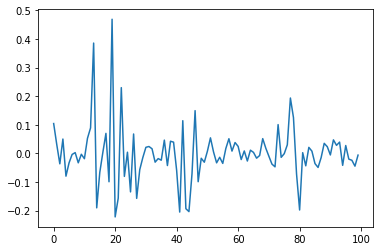

In [631]:
pyplot.plot(svd.components_[:, word_idx])

In [632]:
topic_idx = svd.components_[:, word_idx].argmax()
topic_idx

19

In [633]:
topic = pd.DataFrame({'word': words, 'loading': svd.components_[topic_idx]})
topic.sort_values('loading').tail()

,word,loading
299,립밤,0.161091
291,립,0.171528
850,촉촉하,0.217529
303,립스틱,0.312034
250,디올,0.468840


- SVD 차원 크기 결정

In [634]:
nrow, ncol = tdm.shape

In [635]:
def resample(a):
    return np.random.choice(a, size=nrow)

np.random.seed(2999)
d = np.apply_along_axis(resample, 0, tdm.A)

In [636]:
d.shape

(22699, 1000)

In [637]:
svd2 = TruncatedSVD(n_components=100, random_state=1234)
svd2.fit(d)

TruncatedSVD(n_components=100, random_state=1234)

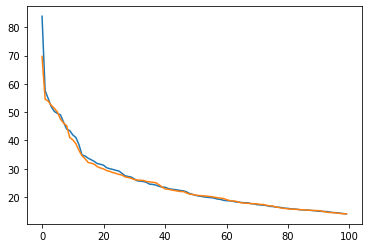

In [638]:
pyplot.plot(svd.singular_values_)
pyplot.plot(svd2.singular_values_)

In [639]:
np.argwhere(svd.singular_values_ - svd2.singular_values_ <= 0)[0]

array([3], dtype=int64)

In [640]:
svd.components_.shape

(100, 1000)

In [641]:
rotator = Rotator()

In [642]:
rot = rotator.fit_transform(svd.components_.T)

In [643]:
loading = rot.T

In [644]:
word_idx = words.index('디올')

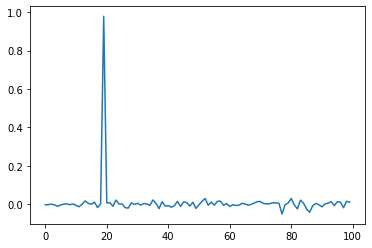

In [645]:
pyplot.plot(loading[:, word_idx])

In [646]:
topic_idx = loading[:, word_idx].argmax()
topic_idx

19

In [648]:
topic = pd.DataFrame({'word': words, 'loading': loading[topic_idx]})
topic.sort_values('loading').tail(10)

,word,loading
54,가,0.020215
348,몇년,0.020664
577,어딕트,0.022841
281,로즈우드,0.024144
270,라즈베리,0.029368
297,립글로즈,0.030628
47,ㅎ,0.033789
299,립밤,0.035319
138,글로우,0.037692
250,디올,0.979485


In [649]:
word_idx = words.index('입생로랑')

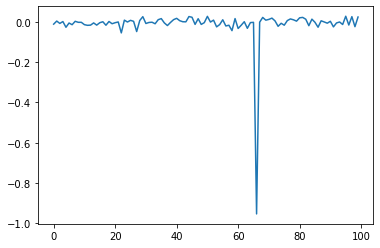

In [650]:
pyplot.plot(loading[:, word_idx])

In [651]:
topic_idx = loading[:, word_idx].argmax()
topic_idx

95

In [652]:
topic = pd.DataFrame({'word': words, 'loading': loading[topic_idx]})
topic.sort_values('loading').tail(10)

,word,loading
179,느끼,0.069089
426,분,0.072912
144,기분,0.079198
319,말,0.081535
147,기존,0.103220
380,발림,0.113200
94,겨울,0.120940
338,매트,0.158025
73,강추,0.172827
455,사람,0.822093


- NMF

여러 차원으로 진행한 후 가장 적당한 50으로 주제 분석을 진행했다.

In [370]:
nmf = NMF(n_components=50, random_state=1234)
doc_topics = nmf.fit_transform(tdm)

C:\Users\gimje\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


In [371]:
loading = nmf.components_

In [372]:
word_idx = words.index('디올')

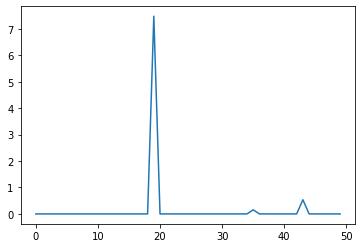

In [373]:
pyplot.plot(loading[:, word_idx])

In [374]:
topic_idx = loading[:, word_idx].argmax()
topic_idx

19

In [375]:
topic = pd.DataFrame({'word': words, 'loading': loading[topic_idx]})
topic.sort_values('loading').tail(10)

,word,loading
670,유명,0.162799
94,겨울,0.166751
270,라즈베리,0.167059
298,립글롭,0.181220
577,어딕트,0.295703
853,최고,0.319355
48,ㅎㅎ,0.328428
415,보습력,0.346009
295,립글로우,2.446068
250,디올,7.477682


In [376]:
word_idx = words.index('입생로랑')

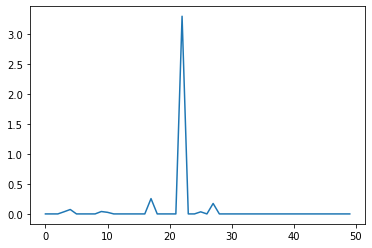

In [377]:
pyplot.plot(loading[:, word_idx])

In [378]:
topic_idx = loading[:, word_idx].argmax()
topic_idx

22

In [379]:
topic = pd.DataFrame({'word': words, 'loading': loading[topic_idx]})
topic.sort_values('loading').tail(10)

,word,loading
679,은,0.243298
527,수,0.267821
713,인생,0.359481
853,최고,0.481804
822,진짜,0.488557
670,유명,0.648447
843,처음,0.822885
725,입생,1.153958
727,입생로랑,3.299883
908,틴트,8.713272


### LDA - DIOR

dior 리뷰에 대해 LDA로 주제 분석을 진행했다. 사용감과 관련한 주제인 69번 주제와, 색상과 관련한 주제인 71번 주제 등 dior 립 제품의 특징들이 묶인 주제들을 찾아볼 수 있었다.

In [603]:
token_re = re.compile(r'\b\w{2,}\b', re.UNICODE)
def tokenizer(text):
    text = text.lower()
    words = []
    for word in token_re.findall(text):
        words.append(word)
    return words

In [604]:
docs = []
for text in dior.review:
    doc = tokenizer(text)
    docs.append(doc)

In [605]:
dic = Dictionary(docs)

In [606]:
dic.filter_extremes(no_below=10, no_above=0.9)

In [607]:
corpus = []
for doc in docs:
    bow = dic.doc2bow(doc)
    corpus.append(bow)

In [608]:
train_corpus, valid_corpus = train_test_split(corpus, test_size=0.1, random_state=5432)

In [609]:
model = LdaModel(
    corpus=train_corpus,
    id2word=dic,
    num_topics=100,
    random_state=1234)

In [610]:
loss = model.log_perplexity(valid_corpus)

In [611]:
old_loss = -np.inf

In [612]:
while loss > old_loss + 0.1:
    model.update(train_corpus)
    old_loss = loss
    loss = model.log_perplexity(valid_corpus)
    print(loss)

-15.28087303238256
-14.95374089928709
-14.819169654874067
-14.764215490089052


In [613]:
model.save('dior-model')

In [614]:
!zip dior-.zip dior-model*

updating: dior-model (deflated 60%)
updating: dior-model.expElogbeta.npy (deflated 96%)
updating: dior-model.id2word (deflated 49%)
updating: dior-model.state (deflated 70%)


In [615]:
model = LdaModel.load('dior-model')

In [616]:
model.show_topic(0)

[('정말', 0.52655834),
 ('추천합니다', 0.09420533),
 ('있어', 0.063132234),
 ('자연스러워요', 0.06168836),
 ('향도', 0.05623789),
 ('주셔서', 0.03832548),
 ('써도', 0.030613013),
 ('주문해서', 0.027776353),
 ('쓸게요', 0.023275303),
 ('그렇지만', 0.019764168)]

In [617]:
dic.token2id['디올']

45

In [618]:
model.get_term_topics(45, 0.01)

[(42, 0.59148026)]

In [619]:
model.show_topic(42)

[('디올', 0.5915028),
 ('글로우', 0.12081336),
 ('어딕트', 0.106849715),
 ('립글로우', 0.087311774),
 ('핑크빛이', 0.033063535),
 ('35g', 0.022217926),
 ('여전히', 0.01191816),
 ('만족하는', 0.01162783),
 ('오랜만에', 0.010945305),
 ('입니다', 0.00089557574)]

In [620]:
pyLDAvis.enable_notebook()

In [621]:
p = pyLDAvis.gensim.prepare(model, corpus, dic, sort_topics=False)

In [622]:
pyLDAvis.display(p) 

In [623]:
coh = CoherenceModel(model=model, corpus=corpus, texts=docs, dictionary=dic, coherence='c_v')

In [624]:
coh.get_coherence()

0.35407076807066545

In [625]:
topn = 25
top_words = set()

for topic in range(model.num_topics):
    for word, prob in model.show_topic(topic, topn=topn):
        top_words.add(word)

In [626]:
len(top_words)

1081

In [627]:
1072 / 2500  

0.4288

### LDA - YSL

ysl 리뷰에 대해 LDA로 주제 분석을 진행했다. 제형에 관련한 주제인 86번 주제와, 인기있는 색상과 관련한 주제인 93번 주제 등 ysl 립 제품의 특징들이 묶인 주제들을 찾아볼 수 있었다.

In [576]:
token_re = re.compile(r'\b\w{2,}\b', re.UNICODE)
def tokenizer(text):
    text = text.lower()
    words = []
    for word in token_re.findall(text):
        words.append(word)
    return words

In [577]:
docs = []
for text in ysl.review:
    doc = tokenizer(text)
    docs.append(doc)

In [578]:
dic = Dictionary(docs)

In [579]:
dic.filter_extremes(no_below=10, no_above=0.9)

In [580]:
corpus = []
for doc in docs:
    bow = dic.doc2bow(doc)
    corpus.append(bow)

In [581]:
train_corpus, valid_corpus = train_test_split(corpus, test_size=0.1, random_state=5432)

In [582]:
model = LdaModel(
    corpus=train_corpus,
    id2word=dic,
    num_topics=100,
    random_state=1234)

In [583]:
loss = model.log_perplexity(valid_corpus)

In [584]:
old_loss = -np.inf

In [586]:
while loss > old_loss + 0.1:
    model.update(train_corpus)
    old_loss = loss
    loss = model.log_perplexity(valid_corpus)
    print(loss)

-15.552061659746132


In [587]:
model.save('ysl-model')

In [588]:
!zip ysl-.zip ysl-model*

  adding: ysl-model (deflated 57%)
  adding: ysl-model.expElogbeta.npy (deflated 95%)
  adding: ysl-model.id2word (deflated 50%)
  adding: ysl-model.state (deflated 63%)


In [589]:
model = LdaModel.load('ysl-model')

In [590]:
model.show_topic(0)

[('선물로', 0.4058966),
 ('친구', 0.1931382),
 ('자연스럽고', 0.14007054),
 ('만족', 0.12490277),
 ('데일리용으로', 0.041928563),
 ('가볍게', 0.026523026),
 ('아쉽네요', 0.02365027),
 ('고민하다', 0.018647896),
 ('핑크빛', 0.018079756),
 ('샀는데', 0.0028793768)]

In [592]:
dic.token2id['입생로랑']

18

In [593]:
model.get_term_topics(18, 0.01)

[(31, 0.09085613), (66, 0.016577965), (97, 0.2415384)]

In [594]:
model.show_topic(31)

[('틴트', 0.31435528),
 ('받았습니다', 0.10345198),
 ('15호', 0.096272744),
 ('입니다', 0.09499012),
 ('살짝', 0.09215402),
 ('입생로랑', 0.09098586),
 ('예쁩니다', 0.08795509),
 ('알겠어요', 0.03285732),
 ('은은한', 0.03218025),
 ('주문해서', 0.028006634)]

In [595]:
pyLDAvis.enable_notebook()

In [596]:
p = pyLDAvis.gensim.prepare(model, corpus, dic, sort_topics=False)

In [597]:
pyLDAvis.display(p) 

In [598]:
coh = CoherenceModel(model=model, corpus=corpus, texts=docs, dictionary=dic, coherence='c_v')

In [599]:
coh.get_coherence()

0.3405552654061982

In [600]:
topn = 25
top_words = set()

for topic in range(model.num_topics):
    for word, prob in model.show_topic(topic, topn=topn):
        top_words.add(word)

In [601]:
len(top_words)

917

In [602]:
1072 / 2500  

0.4288

## 감사합니다. 